In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Conv1D, Add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Cấu hình GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU đã sẵn sàng! Hệ thống sẽ sử dụng Transformer Encoder.")

GPU đã sẵn sàng! Hệ thống sẽ sử dụng Transformer Encoder.


#PHẦN 1: XỬ LÝ DỮ LIỆU (DATA PIPELINE)

In [3]:
# 1. Load dữ liệu từ Github (Building Data Genome Project 2)
url = "https://github.com/buds-lab/building-data-genome-project-2/blob/master/data/meters/cleaned/electricity_cleaned.csv?raw=true"
df = pd.read_csv(url, index_col='timestamp', parse_dates=True).astype('float32')

In [ ]:
# 2. Tiền xử lý
df = df.interpolate(method='linear', limit_direction='both')
df = df.fillna(0)
# Lọc bỏ các tòa nhà ít dữ liệu (rác)
df = df.loc[:, (df.mean() > 10)]

In [5]:
# 3. Chia tập dữ liệu (Train 70% - Val 20% - Test 10%)
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [6]:
# 4. Chuẩn hóa Min-Max (Quan trọng cho Transformer)
train_min = train_df.min()
train_max = train_df.max()
train_range = train_max - train_min
train_range[train_range == 0] = 1

In [7]:
def min_max_scale(data):
    return (data - train_min) / train_range

In [8]:
train_scaled = min_max_scale(train_df)
val_scaled = min_max_scale(val_df)
test_scaled = min_max_scale(test_df)

In [9]:
del df
gc.collect()

14

#Phần 2: Data Generator

In [10]:
class TransformerGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=256, window_size=48, forecast_horizon=1):
        self.dataset = dataset.values
        self.batch_size = batch_size
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon
        self.n_buildings = self.dataset.shape[1]
        self.n_timesteps = self.dataset.shape[0]
        self.samples_per_building = self.n_timesteps - self.window_size - self.forecast_horizon
        self.total_samples = self.samples_per_building * self.n_buildings

    def __len__(self):
        return int(np.ceil(self.total_samples / self.batch_size)) // 10

    def __getitem__(self, index):
        # Chọn ngẫu nhiên tòa nhà và thời điểm
        building_indices = np.random.randint(0, self.n_buildings, self.batch_size)
        time_starts = np.random.randint(0, self.samples_per_building, self.batch_size)

        X_batch = []
        y_batch = []

        for i in range(self.batch_size):
            b_idx = building_indices[i]
            t_idx = time_starts[i]
            window = self.dataset[t_idx : t_idx + self.window_size, b_idx]
            target = self.dataset[t_idx + self.window_size + self.forecast_horizon - 1, b_idx]
            X_batch.append(window)
            y_batch.append(target)

        return np.array(X_batch)[..., np.newaxis], np.array(y_batch)

In [12]:
# Cấu hình theo bài báo (Window Size đủ lớn để bắt pattern)
BATCH_SIZE = 512
WINDOW_SIZE = 48 # Nhìn lại 2 ngày quá khứ
train_gen = TransformerGenerator(train_scaled, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
val_gen = TransformerGenerator(val_scaled, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)

#Phần 3: Mô hình Transformer

In [13]:
def build_transformer_paper_model(input_shape, head_size=64, num_heads=4, ff_dim=64, num_blocks=2, dropout=0.2):
    inputs = Input(shape=input_shape)

    # Dùng Conv1D làm Positional Encoding "học được" (Learnable Position)
    # Giúp mô hình hội tụ nhanh hơn so với Positional Encoding cố định (Sin/Cos)
    x = Conv1D(filters=head_size, kernel_size=3, padding="same", activation="relu")(inputs)
    x = Dropout(dropout)(x)

    # Khối Transformer Encoder
    for _ in range(num_blocks):
        # 1. Multi-Head Attention
        x_norm = LayerNormalization(epsilon=1e-6)(x)
        attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x_norm, x_norm)
        x = Add()([x, attn_output]) # Residual Connection

        # 2. Feed Forward Network
        x_norm = LayerNormalization(epsilon=1e-6)(x)
        ffn = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x_norm)
        ffn = Dropout(dropout)(ffn)
        ffn = Conv1D(filters=head_size, kernel_size=1)(ffn)
        x = Add()([x, ffn]) # Residual Connection

    # Output Layer
    x = GlobalAveragePooling1D(data_format="channels_last")(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs, name="Transformer_KMeans_Paper")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])
    return model

In [14]:
model = build_transformer_paper_model((WINDOW_SIZE, 1))
model.summary()

Model: "Transformer_KMeans_Paper"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48, 64)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 64)    │        128 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 64)    │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 48, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48, 64)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 48, 64)    │      4,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 48, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 48, 64)    │          0 │ add_1[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 48, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 48, 64)    │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 48, 64)    │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 48, 64)    │          0 │ add_2[0][0],      │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 152,257 (594.75 KB)

 Trainable params: 152,257 (594.75 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

In [16]:
history = model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=callbacks, verbose=1)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3203/3203 ━━━━━━━━━━━━━━━━━━━━ 125s 34ms/step - loss: 0.0293 - mae: 0.1072 - val_loss: 0.8720 - val_mae: 0.0546 - learning_rate: 5.0000e-04
Epoch 2/15
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 110s 34ms/step - loss: 0.0057 - mae: 0.0530 - val_loss: 0.7441 - val_mae: 0.0564 - learning_rate: 5.0000e-04
Epoch 3/15
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - loss: 0.0047 - mae: 0.0477 - val_loss: 0.7756 - val_mae: 0.0497 - learning_rate: 5.0000e-04
Epoch 4/15
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - loss: 0.0044 - mae: 0.0459 - val_loss: 0.6980 - val_mae: 0.0471 - learning_rate: 5.0000e-04
Epoch 5/15
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - loss: 0.0041 - mae: 0.0443 - val_loss: 0.7105 - val_mae: 0.0467 - learning_rate: 5.0000e-04
Epoch 6/15
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 107s 34ms/step - loss: 0.0040 - mae: 0.0434 - val_loss: 0.6197 - val_mae: 0.0451 - learning_rate: 5.0000e-04
Epoch 7/15
3203/3203 ━━━━━━━━━━━━━━━━━━━━ 108s 34ms/step - loss: 0.0040 - mae: 0.0430 - val_loss: 0.7889 

#Phần 4: ANOMALY DETECTION (K-MEANS)

In [18]:
# 4.1. Tìm tòa nhà hợp lệ để test
found_valid = False
while not found_valid:
    idx = random.randint(0, test_scaled.shape[1]-1)
    test_data = test_scaled.iloc[:, idx].values
    if np.std(test_data) > 0.05: found_valid = True
    building_name = test_scaled.columns[idx]

In [19]:
# 4.2. Dự báo (Prediction)
def create_eval_seq(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X)[..., np.newaxis], np.array(y)

In [20]:
X_eval, y_eval = create_eval_seq(test_data, WINDOW_SIZE)
y_pred = model.predict(X_eval, verbose=0)

In [21]:
# 4.3. Tính sai số tuyệt đối (Absolute Residuals) - Theo bài báo
residuals = np.abs(y_eval - y_pred.flatten())

In [22]:
# 4.4. Phân cụm K-Means (The Core Logic)
threshold = 0
try:
    # Gom sai số thành 2 cụm: Bình thường & Bất thường
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    kmeans.fit(residuals.reshape(-1, 1))

    # Lấy tâm của 2 cụm
    centers = kmeans.cluster_centers_.flatten()
    # Cụm có tâm lớn hơn chính là cụm Bất thường
    anomaly_center = np.max(centers)
    normal_center = np.min(centers)

    # Xác định ngưỡng: Bài báo gợi ý ngưỡng là ranh giới hoặc tâm cụm bất thường
    # Ở đây ta lấy tâm cụm bất thường làm ngưỡng cứng
    threshold = anomaly_center

    # Fallback: Nếu ngưỡng K-Means quá thấp (nhạy cảm), dùng Thống kê hỗ trợ
    mean_res, std_res = np.mean(residuals), np.std(residuals)
    if threshold < (mean_res + 2*std_res):
        print("-> Ngưỡng K-Means quá thấp, chuyển sang Thống kê (Sigma).")
        threshold = mean_res + 4 * std_res # 4-Sigma rule
    else:
        print(f"-> Áp dụng K-Means thành công. Ngưỡng = {threshold:.4f}")

except Exception as e:
    print(f"-> K-Means lỗi ({e}), chuyển sang Thống kê.")
    threshold = np.mean(residuals) + 4 * np.std(residuals)

-> Áp dụng K-Means thành công. Ngưỡng = 0.3384


# PHẦN 5: TRỰC QUAN HÓA & ĐÁNH GIÁ

In [23]:
# 5.1. Trực quan hóa
anomalies_idx = np.where(residuals > threshold)[0]
b_min = train_min[building_name]
b_range = train_range[building_name]
y_real = y_eval * b_range + b_min
y_pred_real = y_pred.flatten() * b_range + b_min

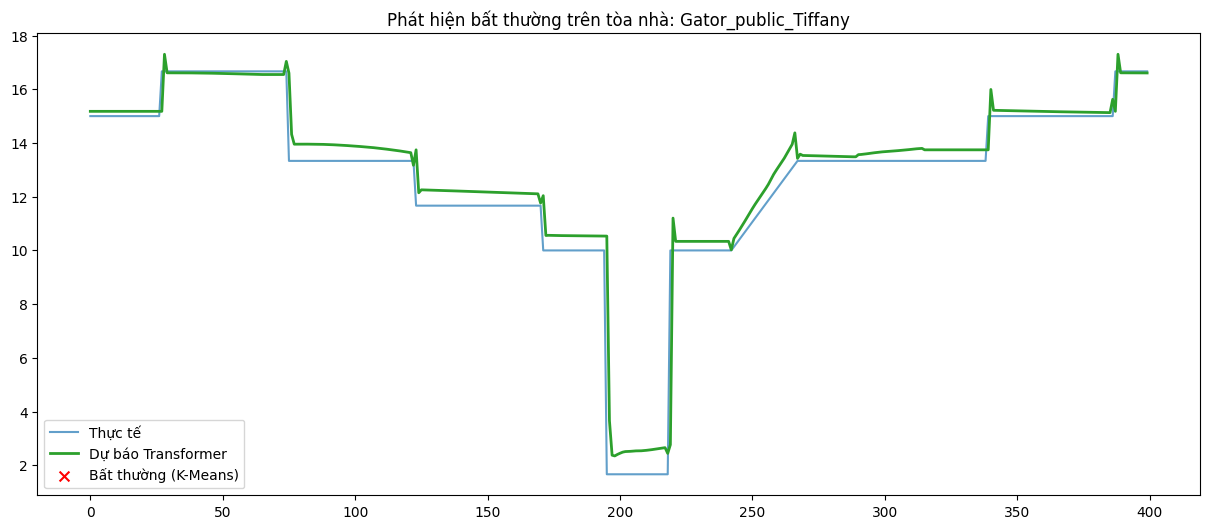

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(y_real[:400], label='Thực tế', color='#1f77b4', alpha=0.7)
plt.plot(y_pred_real[:400], label='Dự báo Transformer', color='#2ca02c', linewidth=2)
if len(anomalies_idx) > 0:
    plt.scatter(anomalies_idx[anomalies_idx<400], y_real[anomalies_idx[anomalies_idx<400]],
                color='red', s=50, label='Bất thường (K-Means)', zorder=10, marker='x')
plt.title(f'Phát hiện bất thường trên tòa nhà: {building_name}')
plt.legend()
plt.show()

In [ ]:
# 5.2. Đánh giá chỉ số (Tiêm lỗi nhân tạo)
y_injected = y_eval.flatten().copy()
labels_true = np.zeros(len(y_injected))

In [26]:
# Tiêm lỗi (x2 giá trị tại 5% điểm ngẫu nhiên)
n_inj = int(len(y_injected) * 0.05)
inj_idx = np.random.choice(len(y_injected), n_inj, replace=False)
y_injected[inj_idx] = y_injected[inj_idx] * 2.0
labels_true[inj_idx] = 1

In [27]:
# Tính lại sai số và phân loại
res_inj = np.abs(y_injected - y_pred.flatten())
labels_pred = (res_inj > threshold).astype(int)

In [28]:
print(f"Precision: {precision_score(labels_true, labels_pred):.4f}")
print(f"Recall:    {recall_score(labels_true, labels_pred):.4f}")
print(f"F1-Score:  {f1_score(labels_true, labels_pred):.4f}")

Precision: 0.9615
Recall:    0.8824
F1-Score:  0.9202
